# Depth estimator for Imagenette

> Depth estimator


- skip_showdoc: true
- skip_exec: true

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

from tqdm import tqdm 
import matplotlib.pyplot as plt
import timm
import numpy as np
from datetime import datetime

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import cv2
from PIL import Image


In [ ]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/ben/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas = midas.eval()


## Data

In [ ]:
transform_default = transforms.Compose([
    transforms.Resize((150, 150)),#??
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
])

In [ ]:
# Download and load the Imagenette dataset
train_dataset = datasets.Imagenette(root='Data',
                                    split='train',
                                    # download=True,
                                    transform=transform_default,
                                    )


# Download and load the Imagenette dataset
test_dataset = datasets.Imagenette(root='Data',
                                  split='val',
                                  # download=True,
                                  transform=transform_default,
                                 )

In [ ]:
len(train_dataset), len(test_dataset)

(9470, 3925)

## Convert

In [ ]:
class ComputeDepth(object):
    def __init__(self, model, transform, device = "cuda"):
        super().__init__()
        self.device = device
        self.model = model
        self.model.to(self.device)
        self.model.eval()
        self.transform = transform
    
    def __call__(self, image):
        input_image = image.to('cpu').squeeze().numpy().transpose(1, 2, 0)
        # input_image = np.array(image)
        input_batch = transform(input_image).to(self.device)
        
        with torch.no_grad():
            prediction = self.model(input_batch)
            
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=input_image.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze(0)
            prediction = prediction.to('cpu')

        prediction_mean = torch.mean(prediction)
        prediction_std = torch.std(prediction)
        
        # Calculate the scaling factors for normalization
        scale_factor = 0.225 / prediction_std
        bias = 0.45 - prediction_mean * scale_factor
        
        # Normalize the tensor to the desired mean and standard deviation
        prediction = prediction * scale_factor + bias
        
        combined_image = torch.cat((image, prediction), dim=0)

        return combined_image

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
image, label = train_dataset[2]

In [ ]:
transform_depth = ComputeDepth(midas, transform = transform, device = "cpu")
new_image = transform_depth(image)

In [ ]:
transposed_image = torch.transpose(new_image[:3], 0, 2).transpose(0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


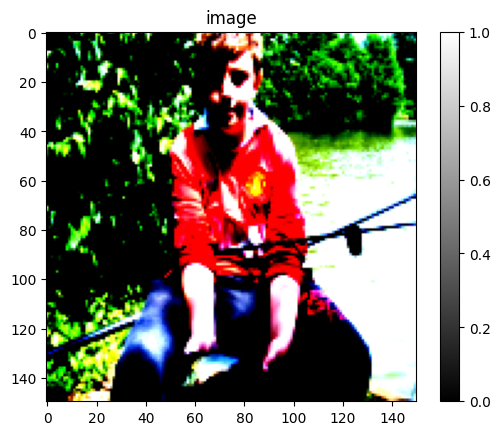

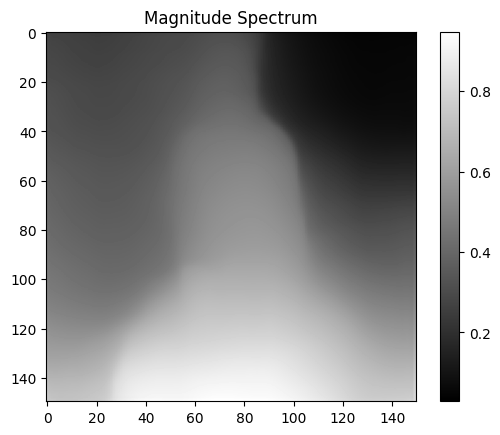

In [ ]:
plt.imshow(transposed_image, cmap='gray')
plt.title('image')
plt.colorbar()
plt.show()

plt.imshow(new_image[3], cmap='gray')
plt.title('Magnitude Spectrum')
plt.colorbar()
plt.show()

In [ ]:
type(new_image)

torch.Tensor

In [ ]:
new_image.shape

torch.Size([4, 150, 150])

In [ ]:
pil_image = transforms.ToPILImage()(new_image)

In [ ]:
pil_image.__dict__

{'im': <ImagingCore>,
 '_mode': 'RGBA',
 '_size': (150, 150),
 'palette': None,
 'info': {},
 'readonly': 1,
 'pyaccess': None,
 '_exif': None}

In [ ]:
# Save PIL image
pil_image.save("image_with_4_channels.png")

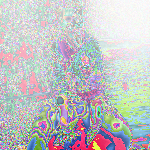

In [ ]:
# Open the 4-channel image using PIL
pil_image = Image.open("image_with_4_channels.png")
pil_image